Default Credit Cards Clients

A bank in you region want to build a model to predict credit card defaulters more accurately in order minimize money loss. For this task we have a set of data on default payments and demographic data to help us do our task. Data is comprised in the following CSV files:


**TRAINING**

**`train_customers.csv`**
 - `ID`: ID of each client
 - `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
 - `SEX`: Gender (1=male, 2=female)
 - `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
 - `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
 - `AGE`: Age in years
 
**`train_series.csv`**
 - `ID`: ID of each client
 - `MONTH`: The month to wich data is refering
 - `PAY`: Repayment status in the corresponding month (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
 - `BILL_AMT`: Amount of bill statement in the corresponding month (NT dollar)
 - `PAY_AMT`: Amount of previous payment in the corresponding month (NT dollar)
 
**`train_target.csv`**
 - `DEFAULT_JULY`: Default payment in July (1=yes, 0=no)
 
 
**TEST** (For PART 3)
 - **`test_data.csv`**
 
**SUBMISSION** (For PART 3)
 - **`submission_features.csv`**
 
**BACKUP**
 - **`train_data.csv`**

Load all data and answer the following questions

In [6]:
import json
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint, uniform as sp_uniform, boxcox
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import seaborn as sb
import plotly.express as px
import lightgbm as lgb
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from colorama import Fore, Style

# Define color codes
green = Fore.GREEN
bold = Style.BRIGHT
reset = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")


## **A. DATA ENGINEERING**

Load the train_series.csv file and pivot the time-dependent columns (PAY, BILL_AMT, and PAY_AMT) to build one column of these per month. (Ex. PAY_JUNE, PAY_MAY, ..., BILL_AMT_JUNE, ...)


In [147]:
cd /Users/johanbarreiro/Documents/IE University/Python For Data Analysis II/Individual Assignment/

/Users/johanbarreiro/Documents/IE University/Python For Data Analysis II/Individual Assignment


In [148]:
df = pd.read_csv("train_series.csv", sep = "," )
print(len(df))
df.head()

90000


ID     MONTH  PAY  BILL_AMT  PAY_AMT
0  15936      JUNE  1.0       0.0    797.0
1  15936       MAY -1.0     797.0    190.0
2  15936     APRIL -1.0     190.0   3269.0
3  15936     MARCH -1.0    3260.0  32617.0
4  15936  FEBRUARY -1.0   32617.0   5000.0

In [149]:
df_transformed = df.pivot(index = "ID", columns = "MONTH", values = ['PAY', "BILL_AMT", "PAY_AMT"])
df_transformed.head()

PAY                                  BILL_AMT                    \
MONTH APRIL FEBRUARY JANUARY JUNE MARCH  MAY    APRIL FEBRUARY  JANUARY   
ID                                                                        
0       0.0     -1.0     0.0 -1.0   0.0  0.0  13600.0  44024.0  18697.0   
1       0.0      0.0     0.0  0.0   0.0  0.0  53169.0  50372.0  49470.0   
3      -2.0     -2.0    -2.0 -2.0  -2.0 -2.0      0.0      0.0      0.0   
4       0.0      0.0     0.0  0.0   0.0  0.0   9044.0   9417.0   9617.0   
5       0.0      0.0     0.0  0.0   0.0  0.0  44412.0  35704.0  36524.0   

                                 PAY_AMT                                     \
MONTH     JUNE    MARCH      MAY   APRIL FEBRUARY  JANUARY    JUNE    MARCH   
ID                                                                            
0      28991.0      0.0  24391.0     0.0    680.0  10000.0  1300.0  22373.0   
1      75662.0  50875.0  70073.0  2000.0   1903.0   2006.0  3212.0   1603.0   
3      23570.0      0.0    735.0     0.0      0.0      0.0   742.0      0.0   
4       8214.0   9225.0   8034.0   331.0    356.0    330.0  1140.0    341.0   
5      50840.0  45402.0  49592.0  1837.0   1254.0   1387.0  2100.0   1139.0   

               
MONTH     MAY  
ID             
0      1000.0  
1      2106.0  
3         0.0  
4      1150.0  
5      1847.0

In [150]:
df_transformed.columns = ['_'.join(col) for col in df_transformed.columns]
df_transformed.reset_index(inplace=True)
df_transformed.head()

ID  PAY_APRIL  PAY_FEBRUARY  PAY_JANUARY  PAY_JUNE  PAY_MARCH  PAY_MAY  \
0   0        0.0          -1.0          0.0      -1.0        0.0      0.0   
1   1        0.0           0.0          0.0       0.0        0.0      0.0   
2   3       -2.0          -2.0         -2.0      -2.0       -2.0     -2.0   
3   4        0.0           0.0          0.0       0.0        0.0      0.0   
4   5        0.0           0.0          0.0       0.0        0.0      0.0   

   BILL_AMT_APRIL  BILL_AMT_FEBRUARY  BILL_AMT_JANUARY  BILL_AMT_JUNE  \
0         13600.0            44024.0           18697.0        28991.0   
1         53169.0            50372.0           49470.0        75662.0   
2             0.0                0.0               0.0        23570.0   
3          9044.0             9417.0            9617.0         8214.0   
4         44412.0            35704.0           36524.0        50840.0   

   BILL_AMT_MARCH  BILL_AMT_MAY  PAY_AMT_APRIL  PAY_AMT_FEBRUARY  \
0             0.0       24391.0            0.0             680.0   
1         50875.0       70073.0         2000.0            1903.0   
2             0.0         735.0            0.0               0.0   
3          9225.0        8034.0          331.0             356.0   
4         45402.0       49592.0         1837.0            1254.0   

   PAY_AMT_JANUARY  PAY_AMT_JUNE  PAY_AMT_MARCH  PAY_AMT_MAY  
0          10000.0        1300.0        22373.0       1000.0  
1           2006.0        3212.0         1603.0       2106.0  
2              0.0         742.0            0.0          0.0  
3            330.0        1140.0          341.0       1150.0  
4           1387.0        2100.0         1139.0       1847.0

Load train_customers.csv and include the pivoted table of time series data. The resulting table must be a table with one row per customer (ID)

In [151]:
df_customers = pd.read_csv("train_customers.csv", sep = "," )
df_customers.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE
0  15936   140000.0    2          1         1   39
1  15248    90000.0    2          2         1   49
2  27163   150000.0    2          1         1   37
3  13955   160000.0    1          3         1   38
4  23604   360000.0    1          2         1   28

In [152]:
df_merge = pd.merge(df_customers, df_transformed, on = "ID")
df_merge.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_APRIL  PAY_FEBRUARY  \
0  15936   140000.0    2          1         1   39       -1.0          -1.0   
1  15248    90000.0    2          2         1   49       -2.0          -1.0   
2  27163   150000.0    2          1         1   37       -1.0           0.0   
3  13955   160000.0    1          3         1   38        0.0           0.0   
4  23604   360000.0    1          2         1   28        2.0          -2.0   

   PAY_JANUARY  PAY_JUNE  ...  BILL_AMT_JANUARY  BILL_AMT_JUNE  \
0          0.0       1.0  ...           20506.0            0.0   
1         -1.0       1.0  ...            6990.0            0.0   
2         -1.0      -1.0  ...            1914.0         4787.0   
3          0.0       0.0  ...            7083.0        25003.0   
4         -2.0      -2.0  ...               0.0            0.0   

   BILL_AMT_MARCH  BILL_AMT_MAY  PAY_AMT_APRIL  PAY_AMT_FEBRUARY  \
0          3260.0         797.0         3269.0            5000.0   
1          2146.0           0.0         2146.0            6990.0   
2          1291.0        1046.0         1193.0            3000.0   
3         15778.0       23621.0         5000.0               0.0   
4             0.0        2500.0            0.0               0.0   

   PAY_AMT_JANUARY  PAY_AMT_JUNE  PAY_AMT_MARCH  PAY_AMT_MAY  
0           2774.0         797.0        32617.0        190.0  
1           3550.0           0.0         2452.0          0.0  
2              0.0        1054.0            0.0        344.0  
3              0.0        2000.0         1500.0       5060.0  
4              0.0        2500.0            0.0          0.0  

[5 rows x 24 columns]

Include information from the target (train_target.csv) on the table


In [153]:
df_target = pd.read_csv("train_target.csv", sep = ",")
df_target.head()

ID  DEFAULT_JULY
0  15936             0
1  15248             1
2  27163             0
3  13955             0
4  23604             0

In [154]:
df_merged = pd.merge(df_merge, df_target, on = "ID")
df_merged.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_APRIL  PAY_FEBRUARY  \
0  15936   140000.0    2          1         1   39       -1.0          -1.0   
1  15248    90000.0    2          2         1   49       -2.0          -1.0   
2  27163   150000.0    2          1         1   37       -1.0           0.0   
3  13955   160000.0    1          3         1   38        0.0           0.0   
4  23604   360000.0    1          2         1   28        2.0          -2.0   

   PAY_JANUARY  PAY_JUNE  ...  BILL_AMT_JUNE  BILL_AMT_MARCH  BILL_AMT_MAY  \
0          0.0       1.0  ...            0.0          3260.0         797.0   
1         -1.0       1.0  ...            0.0          2146.0           0.0   
2         -1.0      -1.0  ...         4787.0          1291.0        1046.0   
3          0.0       0.0  ...        25003.0         15778.0       23621.0   
4         -2.0      -2.0  ...            0.0             0.0        2500.0   

   PAY_AMT_APRIL  PAY_AMT_FEBRUARY  PAY_AMT_JANUARY  PAY_AMT_JUNE  \
0         3269.0            5000.0           2774.0         797.0   
1         2146.0            6990.0           3550.0           0.0   
2         1193.0            3000.0              0.0        1054.0   
3         5000.0               0.0              0.0        2000.0   
4            0.0               0.0              0.0        2500.0   

   PAY_AMT_MARCH  PAY_AMT_MAY  DEFAULT_JULY  
0        32617.0        190.0             0  
1         2452.0          0.0             1  
2            0.0        344.0             0  
3         1500.0       5060.0             0  
4            0.0          0.0             0  

[5 rows x 25 columns]

In [155]:
df_merged.to_csv('Merged_Train_Data.csv', index=False)

## **B. EXPLORATORY DATA ANALYSIS**
Let's do some exploratory data analysis over the training data obtained from the previous part.

### Represent the distribution of the target in a chart


DEFAULT_JULY
0    11659
1     3341
Name: count, dtype: int64


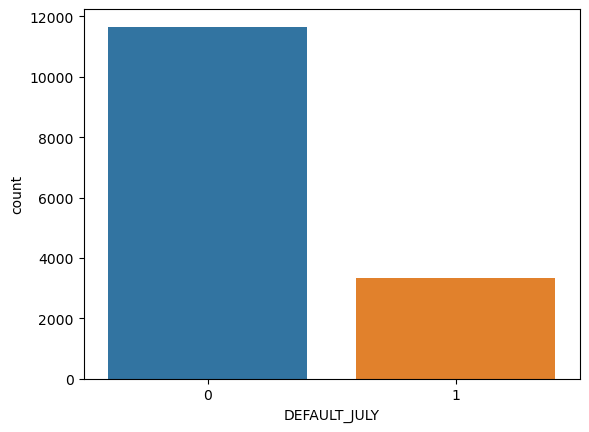

In [156]:
sb.countplot(data=df_merged, x='DEFAULT_JULY')
print(df_merged['DEFAULT_JULY'].value_counts())

Data is imbalanced with roughly 1/3 defaults as non defaults.

### Plotting the univariate distribution of all features. Comment the results.

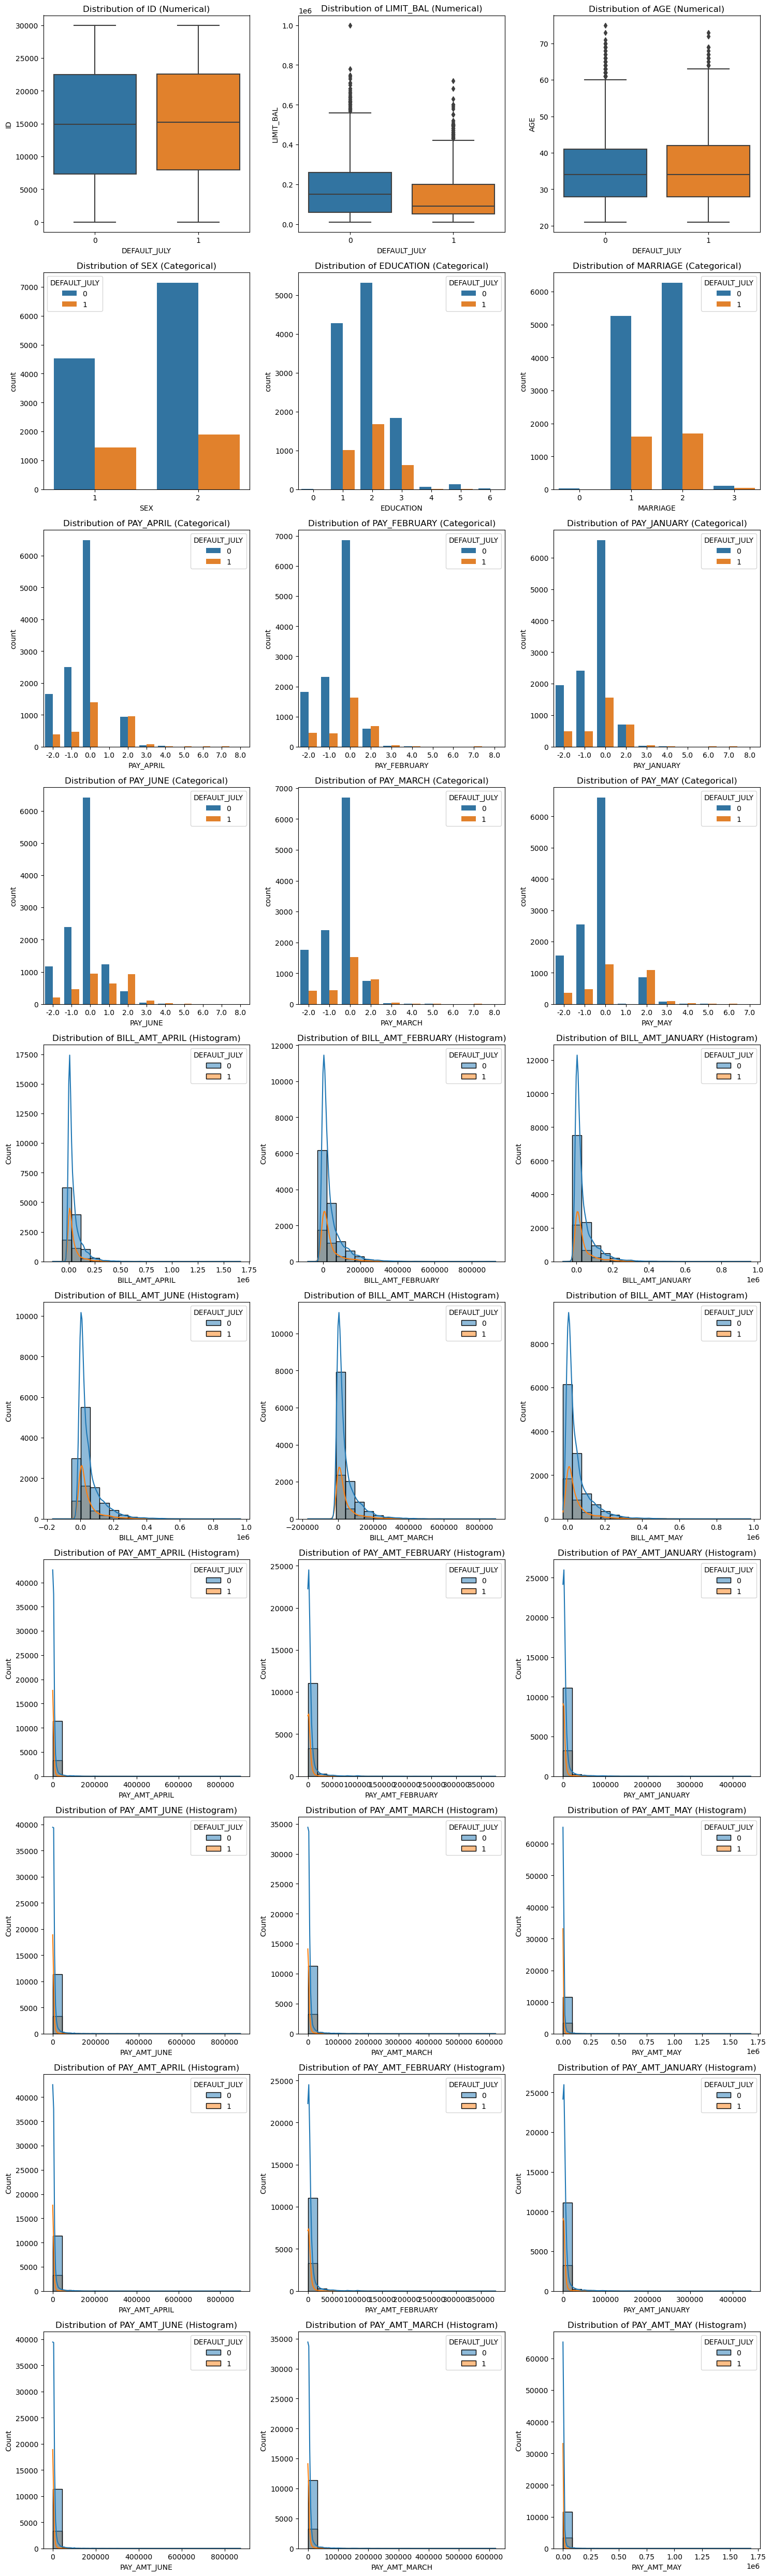

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Assuming df_merged is your DataFrame

# Define numerical, categorical, and histogram column names
numerical_cols = ['ID', 'LIMIT_BAL', 'AGE']  
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_APRIL', 'PAY_FEBRUARY', 'PAY_JANUARY', 
                    'PAY_JUNE', 'PAY_MARCH', 'PAY_MAY']  
histogram_cols = ['BILL_AMT_APRIL', 'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MARCH', 'BILL_AMT_MAY', 'PAY_AMT_APRIL',
       'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MARCH',
       'PAY_AMT_MAY', 'PAY_AMT_APRIL',
       'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MARCH',
       'PAY_AMT_MAY'] 
target_col = 'DEFAULT_JULY'

df_merged['DEFAULT_JULY'] = df_merged['DEFAULT_JULY'].astype(str)

# Define the number of columns in the grid
num_cols = 3

# Calculate the number of rows needed
num_rows = (len(numerical_cols) + len(categorical_cols) + len(histogram_cols) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

# Loop through numerical columns
for i, num_col in enumerate(numerical_cols):
    sb.boxplot(data=df_merged, x=target_col, y=num_col, ax=axes[i])
    axes[i].set_title(f'Distribution of {num_col} (Numerical)')

# Loop through categorical columns
for i, cat_col in enumerate(categorical_cols):
    sb.countplot(data=df_merged, x=cat_col, hue=target_col, ax=axes[len(numerical_cols) + i])
    axes[len(numerical_cols) + i].set_title(f'Distribution of {cat_col} (Categorical)')

# Loop through histogram columns and create histograms
for i, hist_col in enumerate(histogram_cols):
    sb.histplot(data=df_merged, x=hist_col, bins=20, kde=True, hue=target_col, ax=axes[len(numerical_cols) + len(categorical_cols) + i])
    axes[len(numerical_cols) + len(categorical_cols) + i].set_title(f'Distribution of {hist_col} (Histogram)')

# Remove any unused subplots
for i in range(len(numerical_cols) + len(categorical_cols) + len(histogram_cols), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

df_merged['DEFAULT_JULY'] = df_merged['DEFAULT_JULY'].astype(int)


Boxplots were used for numerical columns except for the pay_amount and bill_amount columns, the data is so focused around 0 with a long tail making a boxplot barely legible. While histograms are an improvement it is not much better. Barplots however work well for categorical variables. Difference between target values are subtle, the most noticable is in limit balance but it is still quite subtle. Feature importance plots will likely reveal more information about plot importance.

### Plotting a 3D chart using Plotly. 

In [158]:
df_merged.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_APRIL',
       'PAY_FEBRUARY', 'PAY_JANUARY', 'PAY_JUNE', 'PAY_MARCH', 'PAY_MAY',
       'BILL_AMT_APRIL', 'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MARCH', 'BILL_AMT_MAY', 'PAY_AMT_APRIL',
       'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MARCH',
       'PAY_AMT_MAY', 'DEFAULT_JULY'],
      dtype='object')

In [159]:
fig = px.scatter_3d(df_merged, x='EDUCATION', y='AGE', z='DEFAULT_JULY', color='DEFAULT_JULY',
                    symbol='DEFAULT_JULY', opacity=0.7, size_max=20)
fig.update_layout(scene=dict(xaxis_title='EDUCATION', yaxis_title='Age', zaxis_title='DEFAULT_JULY'), margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## **MACHINE LEARNING**
The goal is to build a good machine learning model to estimate the probability of default of the customers and establish some recomendations to the company about how to use the output of the model. For this part, we will use three additional datasets:


train_data.csv - A backup of the data from data engineering step with matching schema to test_data and submission_features
test_data.csv - Contains new data from 8000 customers with the same structure as the training data from Part 1. It contains all the features and the target already joined. You can use this data set for testing purposes (or you can build your own test set from the training set). Anyway, keep it because you will need it for question C.2
submission_features.csv - This contains data associated with unseen 7000 customers, but without the target. Used to provide the submission on Kaggle.

### Build a machine learning model to estimate the probability of default.


In [160]:
test_data = pd.read_csv('test_data.csv')
train_data = pd.read_csv('train_data.csv')
submission_features = pd.read_csv('submission_features.csv')

In [161]:
print(df_merged.columns)
print(train_data.columns)
print(test_data.columns)
print(submission_features.columns)


desired_order = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 'PAY_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'BILL_AMT_MARCH',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY',
       'DEFAULT_JULY']
df = df_merged[desired_order]
print(df.columns)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_APRIL',
       'PAY_FEBRUARY', 'PAY_JANUARY', 'PAY_JUNE', 'PAY_MARCH', 'PAY_MAY',
       'BILL_AMT_APRIL', 'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MARCH', 'BILL_AMT_MAY', 'PAY_AMT_APRIL',
       'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MARCH',
       'PAY_AMT_MAY', 'DEFAULT_JULY'],
      dtype='object')
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 'PAY_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'BILL_AMT_MARCH',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY',
       'DEFAULT_JULY'],
      dtype='object')
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY

# Data Cleaning

### Find Nulls

In [162]:
null_values = df.isnull()

# Using .sum() to count the number of null values in each column
null_counts = null_values.sum()

# Printing the number of null values in each column
print("Null value counts:")
print(null_counts)

Null value counts:
ID                   0
LIMIT_BAL            0
SEX                  0
EDUCATION            0
MARRIAGE             0
AGE                  0
PAY_JUNE             0
PAY_MAY              0
PAY_APRIL            0
PAY_MARCH            0
PAY_FEBRUARY         0
PAY_JANUARY          0
BILL_AMT_JUNE        0
BILL_AMT_MAY         0
BILL_AMT_APRIL       0
BILL_AMT_MARCH       0
BILL_AMT_FEBRUARY    0
BILL_AMT_JANUARY     0
PAY_AMT_JUNE         0
PAY_AMT_MAY          0
PAY_AMT_APRIL        0
PAY_AMT_MARCH        0
PAY_AMT_FEBRUARY     0
PAY_AMT_JANUARY      0
DEFAULT_JULY         0
dtype: int64


### Find Outliers

In [163]:
cols = ['LIMIT_BAL', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 'PAY_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'BILL_AMT_MARCH',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY']

outlier_dict = {}
outlier_rows = []

for col in cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier threshold
        upper_bound = Q3 + 5 * IQR

        # Filter rows where the column value is higher than the upper bound (high extreme outliers)
        high_extreme_outliers = df[df[col] > upper_bound]

        # Convert the high extreme outlier values to a list and store in the dictionary
        # Use sorted() to sort the outlier values
        outlier_dict[col] = sorted(high_extreme_outliers[col].tolist())

        # Append the high_extreme_outliers to the list of outlier_rows
        outlier_rows.append(high_extreme_outliers)

# Concatenate all dataframes in outlier_rows
outlier_df = pd.concat(outlier_rows)

# Drop duplicated rows
outlier_df = outlier_df.drop_duplicates()

# Sort dataframe by columns
outlier_df.sort_index(axis=1, inplace=True)

for feature, outliers in outlier_dict.items():
    print(green + bold + feature + reset + ": ", outliers)

LIMIT_BAL:  []
AGE:  []
PAY_JUNE:  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
PAY_MAY:  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
PAY_APRIL:  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0]
PAY_MARCH:  [6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0]
PAY_FEBRUARY:  [6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0]
PAY_JANUARY:  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0]
BILL_AMT_JUNE:  [379039.0, 379080.0, 380417.0, 380502.0, 380781.0, 380933.0, 381453.0, 383973.0, 384846.0, 384919.0,

### Count Outliers

In [164]:
# Iterate over the items in the outlier_dict
total_outliers_count = 0
for feature, outliers in outlier_dict.items():
    # Count the number of outliers for the current feature
    outliers_count = len(outliers)
    
    # Print the feature and the count of outliers
    print(f"{feature}: {outliers_count} rows with outliers")
    
    # Add the count of outliers for the current feature to the total count
    total_outliers_count += outliers_count

# Print the total count of rows with outliers
print(f"Total: {total_outliers_count} rows with outliers")

LIMIT_BAL: 0 rows with outliers
AGE: 0 rows with outliers
PAY_JUNE: 20 rows with outliers
PAY_MAY: 16 rows with outliers
PAY_APRIL: 26 rows with outliers
PAY_MARCH: 32 rows with outliers
PAY_FEBRUARY: 31 rows with outliers
PAY_JANUARY: 31 rows with outliers
BILL_AMT_JUNE: 112 rows with outliers
BILL_AMT_MAY: 115 rows with outliers
BILL_AMT_APRIL: 127 rows with outliers
BILL_AMT_MARCH: 143 rows with outliers
BILL_AMT_FEBRUARY: 134 rows with outliers
BILL_AMT_JANUARY: 133 rows with outliers
PAY_AMT_JUNE: 533 rows with outliers
PAY_AMT_MAY: 506 rows with outliers
PAY_AMT_APRIL: 483 rows with outliers
PAY_AMT_MARCH: 534 rows with outliers
PAY_AMT_FEBRUARY: 503 rows with outliers
PAY_AMT_JANUARY: 552 rows with outliers
Total: 4031 rows with outliers


### Remove Outliers

In [165]:
# Remove duplicated rows from outlier_df
outlier_df = outlier_df.drop_duplicates()

# Get the indices of the rows with outliers
outlier_indices = outlier_df.index.tolist()

# Drop rows with outlier indices from the DataFrame
df_cleaned = df.drop(outlier_indices)

# Display the cleaned DataFrame
print(df_cleaned['DEFAULT_JULY'].value_counts())

DEFAULT_JULY
0    9645
1    3006
Name: count, dtype: int64


In [166]:
# Get the minimum value for all variables
min_values = df.min()

# Print the minimum values
print(min_values)

ID                        0.0
LIMIT_BAL             10000.0
SEX                       1.0
EDUCATION                 0.0
MARRIAGE                  0.0
AGE                      21.0
PAY_JUNE                 -2.0
PAY_MAY                  -2.0
PAY_APRIL                -2.0
PAY_MARCH                -2.0
PAY_FEBRUARY             -2.0
PAY_JANUARY              -2.0
BILL_AMT_JUNE       -165580.0
BILL_AMT_MAY         -24704.0
BILL_AMT_APRIL      -157264.0
BILL_AMT_MARCH      -170000.0
BILL_AMT_FEBRUARY    -81334.0
BILL_AMT_JANUARY     -73895.0
PAY_AMT_JUNE              0.0
PAY_AMT_MAY               0.0
PAY_AMT_APRIL             0.0
PAY_AMT_MARCH             0.0
PAY_AMT_FEBRUARY          0.0
PAY_AMT_JANUARY           0.0
DEFAULT_JULY              0.0
dtype: float64


In [167]:
# Count the number of negative values across columns
negative_counts = (df_cleaned < 0).sum()

# Print the counts
print(negative_counts)

ID                      0
LIMIT_BAL               0
SEX                     0
EDUCATION               0
MARRIAGE                0
AGE                     0
PAY_JUNE             3274
PAY_MAY              3850
PAY_APRIL            3957
PAY_MARCH            4055
PAY_FEBRUARY         4137
PAY_JANUARY          4427
BILL_AMT_JUNE         236
BILL_AMT_MAY          288
BILL_AMT_APRIL        288
BILL_AMT_MARCH        289
BILL_AMT_FEBRUARY     270
BILL_AMT_JANUARY      277
PAY_AMT_JUNE            0
PAY_AMT_MAY             0
PAY_AMT_APRIL           0
PAY_AMT_MARCH           0
PAY_AMT_FEBRUARY        0
PAY_AMT_JANUARY         0
DEFAULT_JULY            0
dtype: int64


In [168]:
df_cleaned.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_JUNE  PAY_MAY  \
1  15248    90000.0    2          2         1   49       1.0     -2.0   
2  27163   150000.0    2          1         1   37      -1.0     -1.0   
3  13955   160000.0    1          3         1   38       0.0      0.0   
4  23604   360000.0    1          2         1   28      -2.0     -1.0   
5  19521   280000.0    1          1         2   32       0.0      0.0   

   PAY_APRIL  PAY_MARCH  ...  BILL_AMT_MARCH  BILL_AMT_FEBRUARY  \
1       -2.0       -1.0  ...          2146.0             2452.0   
2       -1.0        0.0  ...          1291.0             1193.0   
3        0.0        0.0  ...         15778.0             9333.0   
4        2.0        2.0  ...             0.0                0.0   
5        0.0        0.0  ...         31236.0                0.0   

   BILL_AMT_JANUARY  PAY_AMT_JUNE  PAY_AMT_MAY  PAY_AMT_APRIL  PAY_AMT_MARCH  \
1            6990.0           0.0          0.0         2146.0         2452.0   
2            1914.0        1054.0        344.0         1193.0            0.0   
3            7083.0        2000.0       5060.0         5000.0         1500.0   
4               0.0        2500.0          0.0            0.0            0.0   
5             500.0        5000.0       5000.0         5000.0            0.0   

   PAY_AMT_FEBRUARY  PAY_AMT_JANUARY  DEFAULT_JULY  
1            6990.0           3550.0             1  
2            3000.0              0.0             0  
3               0.0              0.0             0  
4               0.0              0.0             0  
5             500.0           4800.0             0  

[5 rows x 25 columns]

### Cleaning Discrete Varaibles - Apply Box Cox - Reorder Columns

In [169]:
def preprocess_data(df):
    # Fix binary variables
    binary_mapping = {1: 0, 2: 1, 3: 0}  # Mapping for fixing binary values
    binary_vars = ['SEX', 'MARRIAGE']  # List of binary variables that need to be fixed
    for var in binary_vars:
        df[var] = df[var].map(binary_mapping)
    df['MARRIAGE_LVL3'] = (df['MARRIAGE'] == 3).astype(int)
    
    # Perform one-hot encoding for 'EDUCATION' column
    education_dummies = pd.get_dummies(df['EDUCATION'], prefix='EDUCATION').astype(int)
    df = pd.concat([df, education_dummies], axis=1)
    df.drop('EDUCATION', axis=1, inplace=True)
    
    # Apply Box-Cox transformation to specified columns
    cols_to_transform = ['LIMIT_BAL', 'AGE', 'PAY_AMT_APRIL', 'PAY_AMT_FEBRUARY', 
                         'PAY_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MARCH', 'PAY_AMT_MAY']
    for col in cols_to_transform:
        shift_value = abs(df[col].min()) + 1 + 1e-6   # Add 1 and a small value to ensure positive values
        transformed_data, _ = boxcox(df[col] + shift_value)
        df[col] = transformed_data
    
    # Reorder columns
    desired_order = ['LIMIT_BAL', 'SEX', 'MARRIAGE', 'MARRIAGE_LVL3', 'AGE', 
                     'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 
                     'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'PAY_JUNE', 
                     'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 
                     'PAY_JANUARY', 'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 
                     'BILL_AMT_MARCH', 'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 
                     'PAY_AMT_JUNE', 'PAY_AMT_MAY', 'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 
                     'PAY_AMT_FEBRUARY', 'PAY_AMT_JANUARY']
    df = df[desired_order]
    
    return df

In [170]:
# Prepare features and target variable

df = df_cleaned

print(df['DEFAULT_JULY'].value_counts())

X = df.drop(columns=['DEFAULT_JULY', 'ID'])  # Features
y = df['DEFAULT_JULY']  # Target variable

DEFAULT_JULY
0    9645
1    3006
Name: count, dtype: int64


In [171]:
X = preprocess_data(X)

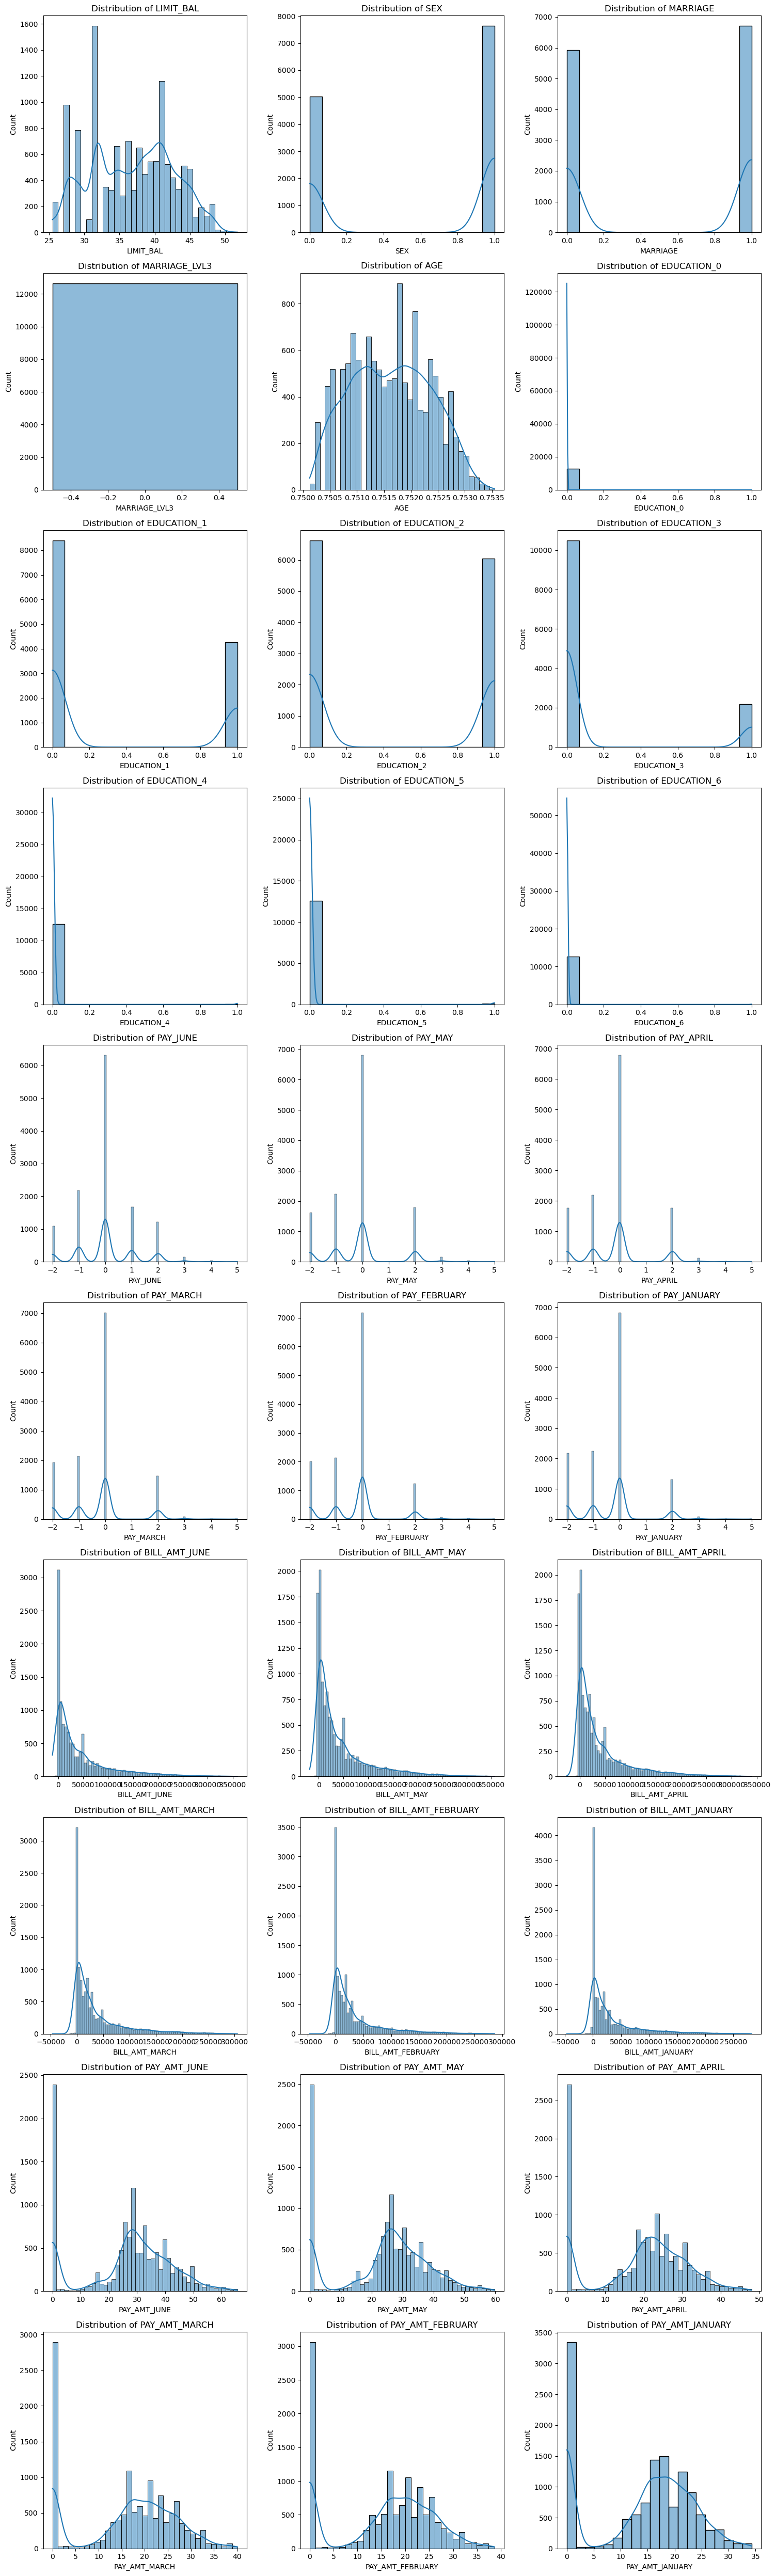

In [172]:
# Define the number of columns in the grid
num_cols = 3

# Extract feature names
features = X.columns

# Calculate the number of rows needed
num_rows = (len(features) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

# Loop through each feature and plot its distribution
for i, feature in enumerate(features):
    sb.histplot(data=X, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Remove any unused subplots
for i in range(len(features), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

### Balancing the Data Set

In [173]:
# # Initialize SMOTE
# smote = SMOTE(random_state=42)

# # Perform SMOTE resampling
# X_resampled, y_resampled = smote.fit_resample(X, y)

# print(y_resampled.value_counts())

In [174]:
# # Initialize RandomOverSampler
# ros = RandomOverSampler(random_state=42)

# # Perform random oversampling
# X_resampled, y_resampled = ros.fit_resample(X, y)

# print(len(X_resampled), y_resampled.value_counts())

In [175]:
# # Initialize RandomUnderSampler
# rus = RandomUnderSampler(random_state=42)

# # Perform random undersampling
# X_resampled, y_resampled = rus.fit_resample(X, y)
# print(len(X_resampled), y_resampled.value_counts())

In [176]:
# X_train = X_resampled
# y_train = y_resampled

X_train = X
y_train = y

### Use Data Cleaing with LGBM and Random Search

# New Attempts

The traditional method of data cleaning and balancing the dataset resulted in poor ROC-AUC scores. Since Kaggle will act as a test set we can combine test and train to create a super-train set. 

In [177]:
test_data = pd.read_csv('test_data.csv')
train_data = pd.read_csv('train_data.csv')
submission_features = pd.read_csv('submission_features.csv')

In [178]:
super_train = pd.concat([train_data, test_data], ignore_index=True)

X = super_train.drop(columns=['DEFAULT_JULY', 'ID'])  # Features
y = super_train['DEFAULT_JULY']  # Target variable

Data Cleaning yielded no improvement on based lightgbm performance, in fact performance worsened.

# XG BOOST

In [179]:
# Define XGBoost classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', verbosity=0)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'max_depth': sp_randint(3, 10),
    'learning_rate': sp_uniform(loc=0.01, scale=0.5),
    'subsample': sp_uniform(loc=0.6, scale=0.4),
    'colsample_bytree': sp_uniform(loc=0.6, scale=0.4),
    'gamma': sp_uniform(loc=0, scale=1),
    'reg_alpha': sp_uniform(loc=0, scale=1),
    'reg_lambda': sp_uniform(loc=0, scale=1)
}

# Define ROC-AUC as the evaluation metric
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform hyperparameter tuning with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_distributions, n_iter=50,
                                   scoring=scorer, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                                   random_state=42, verbose=1, n_jobs=-1)

# Perform cross-validation with RandomizedSearchCV
random_search.fit(X, y)

# Get the mean cross-validation ROC-AUC score
mean_cv_score = np.mean(random_search.cv_results_['mean_test_score'])

# Print mean cross-validation ROC-AUC score
print("Mean Cross-Validation ROC-AUC Score:", mean_cv_score)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model using the best hyperparameters
final_model = XGBClassifier(**best_params, verbosity=0)
final_model.fit(X, y)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


Mean Cross-Validation ROC-AUC Score: 0.760495351068229


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.842571623863836, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.009197051616629648, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.060735771433016054, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Random Forest

In [180]:
# Define Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 20),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Define ROC-AUC as the evaluation metric
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform hyperparameter tuning with cross-validation
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions, n_iter=50,
                                   scoring=scorer, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                                   random_state=42, verbose=1, n_jobs=-1)

# Perform cross-validation with RandomizedSearchCV
random_search.fit(X, y)

# Get the mean cross-validation ROC-AUC score
mean_cv_score = np.mean(random_search.cv_results_['mean_test_score'])

# Print mean cross-validation ROC-AUC score
print("Mean Cross-Validation ROC-AUC Score:", mean_cv_score)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model using the best hyperparameters
final_model = RandomForestClassifier(**best_params)
final_model.fit(X, y)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Cross-Validation ROC-AUC Score: nan


RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=8,
                       min_samples_split=5, n_estimators=459)

# LightGBM

### LGBM Base Attempt

In [181]:
# Define LightGBM classifier
lgb_classifier = LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'num_leaves': sp_randint(6, 50),
    'learning_rate': sp_uniform(loc=0.01, scale=0.5),
    'feature_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_freq': sp_randint(1, 10)
}

# Define ROC-AUC as the evaluation metric
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform hyperparameter tuning with cross-validation
random_search = RandomizedSearchCV(estimator=lgb_classifier, param_distributions=param_distributions, n_iter=50,
                                   scoring=scorer, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                                   random_state=42, verbose=1, n_jobs=-1)

# Perform cross-validation with RandomizedSearchCV
cv_scores = cross_val_score(random_search, X, y, cv=5, scoring=scorer)

random_search.fit(X,y)

# Get the mean cross-validation ROC-AUC score
mean_cv_score = np.mean(random_search.cv_results_['mean_test_score'])

# Print mean cross-validation ROC-AUC score
print("Mean Cross-Validation ROC-AUC Score:", mean_cv_score)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model using the best hyperparameters
final_model = LGBMClassifier(**best_params)
final_model.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Cross-Validation ROC-AUC Score: 0.7604329444193512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584617151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568126584617151
[LightGBM] [Warning] bagging_fraction is set=0.761803250848876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761803250848876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584

LGBMClassifier(bagging_fraction=0.761803250848876, bagging_freq=1,
               feature_fraction=0.8568126584617151,
               learning_rate=0.05206998249752442, num_leaves=13)

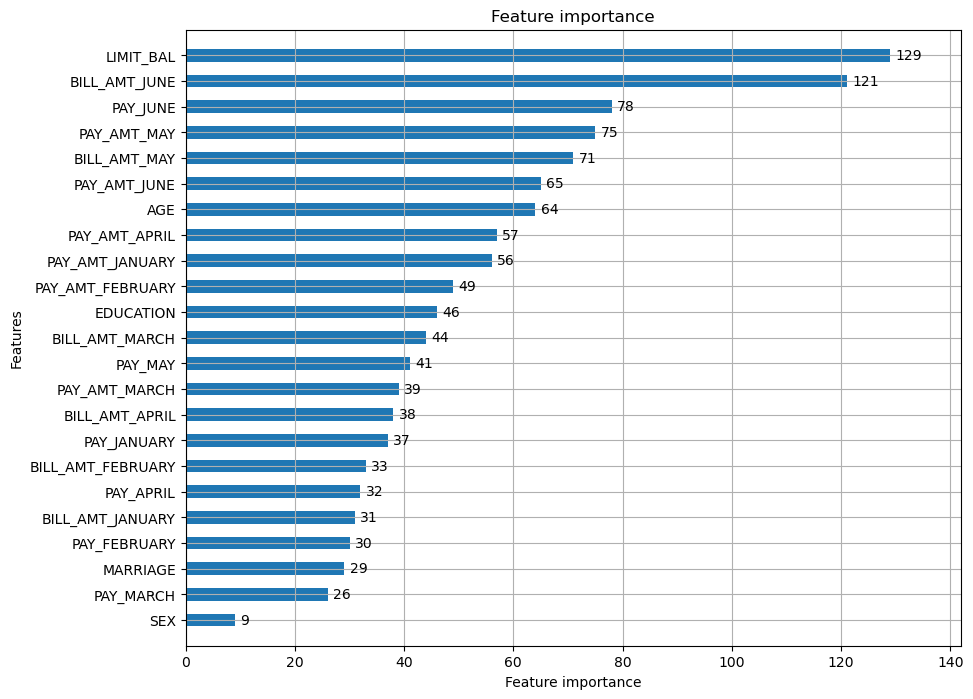

In [182]:
lgb.plot_importance(final_model, height=0.5, figsize=(10, 8))
plt.show()

### Light GBM with RFECV

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Cross-Validation ROC-AUC Score: 0.7604329444193512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584617151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568126584617151
[LightGBM] [Warning] bagging_fraction is set=0.761803250848876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761803250848876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584617151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568126584617151
[LightGBM] [Warning] bagging_fraction is set=0.761803250848876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761803250848876
[LightGBM] [Info] Number of positive: 3379, number of negative: 1195

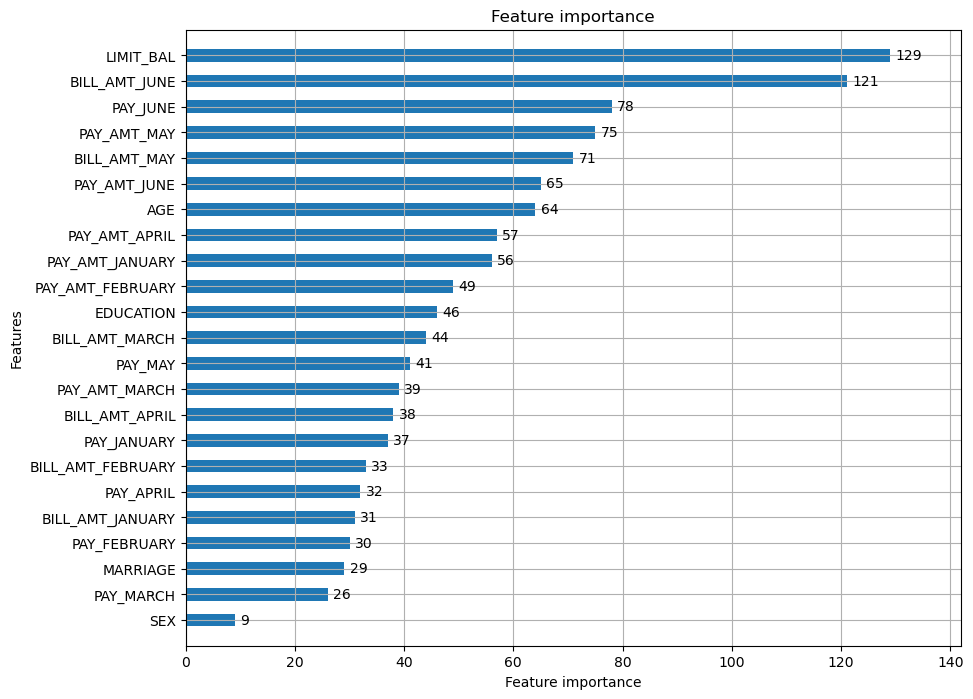

In [183]:
# Define LightGBM classifier
lgb_classifier = LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'num_leaves': sp_randint(6, 50),
    'learning_rate': sp_uniform(loc=0.01, scale=0.5),
    'feature_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_freq': sp_randint(1, 10)
}

# Define ROC-AUC as the evaluation metric
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform hyperparameter tuning with cross-validation
random_search = RandomizedSearchCV(estimator=lgb_classifier, param_distributions=param_distributions, n_iter=50,
                                   scoring=scorer, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                                   random_state=42, verbose=1, n_jobs=-1)

# Perform cross-validation with RandomizedSearchCV
random_search.fit(X, y)

# Get the mean cross-validation ROC-AUC score
mean_cv_score = np.mean(random_search.cv_results_['mean_test_score'])

# Print mean cross-validation ROC-AUC score
print("Mean Cross-Validation ROC-AUC Score:", mean_cv_score)

# Get the best hyperparameters
best_params = random_search.best_params_

# Initialize RFECV
rfecv = RFECV(estimator=LGBMClassifier(**best_params), cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
              scoring=scorer)

# Fit RFECV
rfecv.fit(X, y)

# Get selected features
selected_features = X.columns[rfecv.support_]

# Train the final model using the selected features and best hyperparameters
final_model = LGBMClassifier(**best_params)
final_model.fit(X[selected_features], y)

lgb.plot_importance(final_model, height=0.5, figsize=(10, 8))
plt.show()

In [184]:
print(selected_features)
print(X.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 'PAY_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'BILL_AMT_MARCH',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 'PAY_AMT_FEBRUARY',
       'PAY_AMT_JANUARY'],
      dtype='object')
Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_JUNE',
       'PAY_MAY', 'PAY_APRIL', 'PAY_MARCH', 'PAY_FEBRUARY', 'PAY_JANUARY',
       'BILL_AMT_JUNE', 'BILL_AMT_MAY', 'BILL_AMT_APRIL', 'BILL_AMT_MARCH',
       'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY', 'PAY_AMT_JUNE', 'PAY_AMT_MAY',
       'PAY_AMT_APRIL', 'PAY_AMT_MARCH', 'PAY_AMT_FEBRUARY',
       'PAY_AMT_JANUARY'],
      dtype='object')


This results in a worse score than just LGBM

### LightGBM with Scaling and RFECV

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Cross-Validation ROC-AUC Score: 0.7606578833994853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584617151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568126584617151
[LightGBM] [Warning] bagging_fraction is set=0.761803250848876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761803250848876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584617151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568126584617151
[LightGBM] [Warning] bagging_fraction is set=0.761803250848876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761803250848876
[LightGBM] [Info] Number of positive: 3379, number of negative: 1195

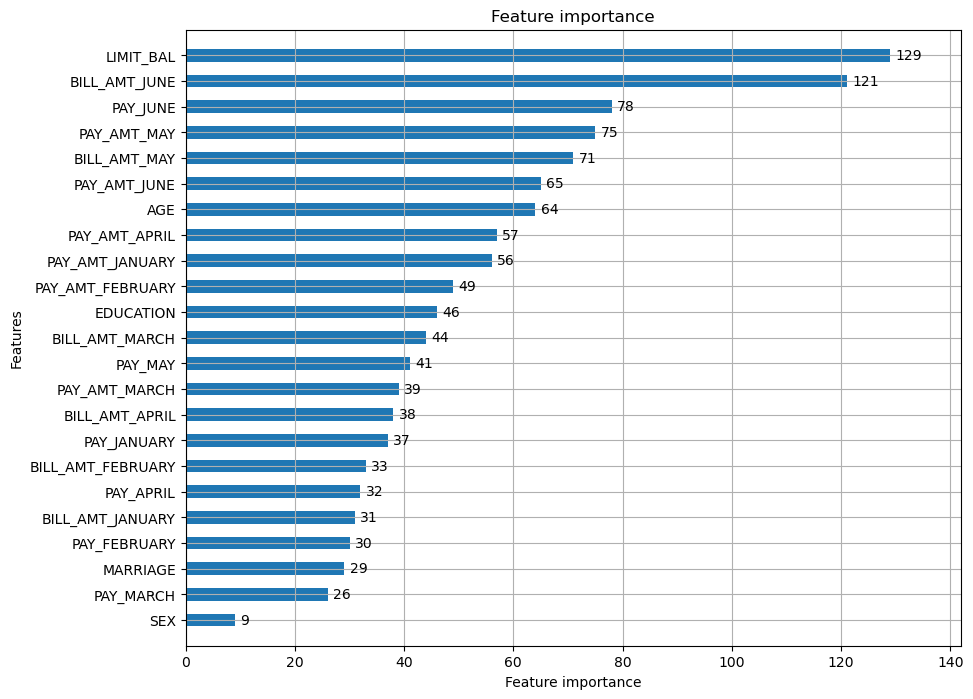

In [185]:
# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Define LightGBM classifier
lgb_classifier = LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'num_leaves': sp_randint(6, 50),
    'learning_rate': sp_uniform(loc=0.01, scale=0.5),
    'feature_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_freq': sp_randint(1, 10)
}

# Define ROC-AUC as the evaluation metric
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform hyperparameter tuning with cross-validation
random_search = RandomizedSearchCV(estimator=lgb_classifier, param_distributions=param_distributions, n_iter=50,
                                   scoring=scorer, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                                   random_state=42, verbose=1, n_jobs=-1)

# Perform cross-validation with RandomizedSearchCV
random_search.fit(X_normalized, y)

# Get the mean cross-validation ROC-AUC score
mean_cv_score = np.mean(random_search.cv_results_['mean_test_score'])

# Print mean cross-validation ROC-AUC score
print("Mean Cross-Validation ROC-AUC Score:", mean_cv_score)

# Get the best hyperparameters
best_params = random_search.best_params_

# Initialize RFECV
rfecv = RFECV(estimator=LGBMClassifier(**best_params), cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
              scoring=scorer)

# Fit RFECV
rfecv.fit(X_normalized, y)

# Get selected features
selected_features = X.columns[rfecv.support_]

# Train the final model using the selected features and best hyperparameters
final_model = LGBMClassifier(**best_params)
final_model.fit(X[selected_features], y)

lgb.plot_importance(final_model, height=0.5, figsize=(10, 8))
plt.show()


This results in a worse score than just LGBM.

### LightGBM with manual feature selection

Fitting 3 folds for each of 50 candidates, totalling 150 fits


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mean Cross-Validation ROC-AUC Score: 0.7597390313900776
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584617151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568126584617151
[LightGBM] [Warning] bagging_fraction is set=0.761803250848876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.761803250848876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8568126584617151, colsample_bytree=1.0 will be ignored. Current value: f

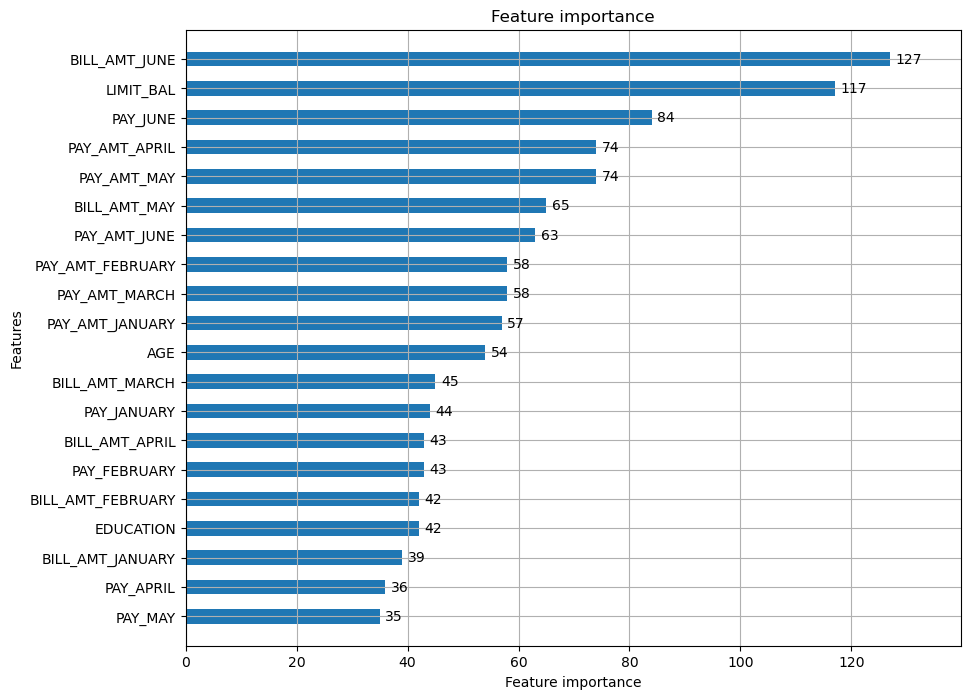

In [186]:
# Select Features
X_selected = super_train.drop(columns=['DEFAULT_JULY', 'ID', 'SEX', 'PAY_MARCH', 'MARRIAGE'])  # Features

# Define LightGBM classifier
lgb_classifier = LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)

# Define parameter grid for RandomizedSearchCV
param_distributions = {
    'num_leaves': sp_randint(6, 50),
    'learning_rate': sp_uniform(loc=0.01, scale=0.5),
    'feature_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_fraction': sp_uniform(loc=0.6, scale=0.4),
    'bagging_freq': sp_randint(1, 10)
}

# Define ROC-AUC as the evaluation metric
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform hyperparameter tuning with cross-validation
random_search = RandomizedSearchCV(estimator=lgb_classifier, param_distributions=param_distributions, n_iter=50,
                                   scoring=scorer, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                                   random_state=42, verbose=1, n_jobs=-1)

# Perform cross-validation with RandomizedSearchCV
cv_scores = cross_val_score(random_search, X_selected, y, cv=5, scoring=scorer)

random_search.fit(X_selected,y)

# Get the mean cross-validation ROC-AUC score
mean_cv_score = np.mean(random_search.cv_results_['mean_test_score'])

# Print mean cross-validation ROC-AUC score
print("Mean Cross-Validation ROC-AUC Score:", mean_cv_score)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model using the best hyperparameters
final_model = LGBMClassifier(**best_params)
final_model.fit(X_selected, y)

lgb.plot_importance(final_model, height=0.5, figsize=(10, 8))
plt.show()

This results in a worse score than just LGBM

### LightGBM with Optuna

In [200]:
super_train = pd.concat([train_data, test_data], ignore_index=True)

X = super_train.drop(columns=['DEFAULT_JULY', 'ID'])  # Features
y = super_train['DEFAULT_JULY']  # Target variable

[I 2024-02-27 10:54:19,401] A new study created in memory with name: no-name-666ae877-a362-48fd-8ed6-920a5647a7fa
[I 2024-02-27 10:54:20,317] Trial 0 finished with value: 0.7812528660826535 and parameters: {'num_leaves': 267, 'max_depth': 3, 'learning_rate': 0.2292386157005599, 'feature_fraction': 0.9850958494277559, 'bagging_fraction': 0.8392046365933596, 'bagging_freq': 2, 'min_child_samples': 33, 'reg_alpha': 0.006487976846343222, 'reg_lambda': 66.81738451426403}. Best is trial 0 with value: 0.7812528660826535.
[I 2024-02-27 10:54:23,275] Trial 1 finished with value: 0.742036894132191 and parameters: {'num_leaves': 548, 'max_depth': 12, 'learning_rate': 0.20898129661107762, 'feature_fraction': 0.2426358568578092, 'bagging_fraction': 0.23737105282853802, 'bagging_freq': 2, 'min_child_samples': 55, 'reg_alpha': 0.0029042177922975294, 'reg_lambda': 3.341948160504749e-05}. Best is trial 0 with value: 0.7812528660826535.
[I 2024-02-27 10:54:25,818] Trial 2 finished with value: 0.77336805

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5106510494513434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106510494513434
[LightGBM] [Warning] bagging_fraction is set=0.8621655870184399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621655870184399
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5106510494513434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106510494513434
[LightGBM] [Warning] bagging_fraction is set=0.8621655870184399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621655870184399
[LightGBM] [Info] Number of positive: 5069, number of negative: 17931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can 

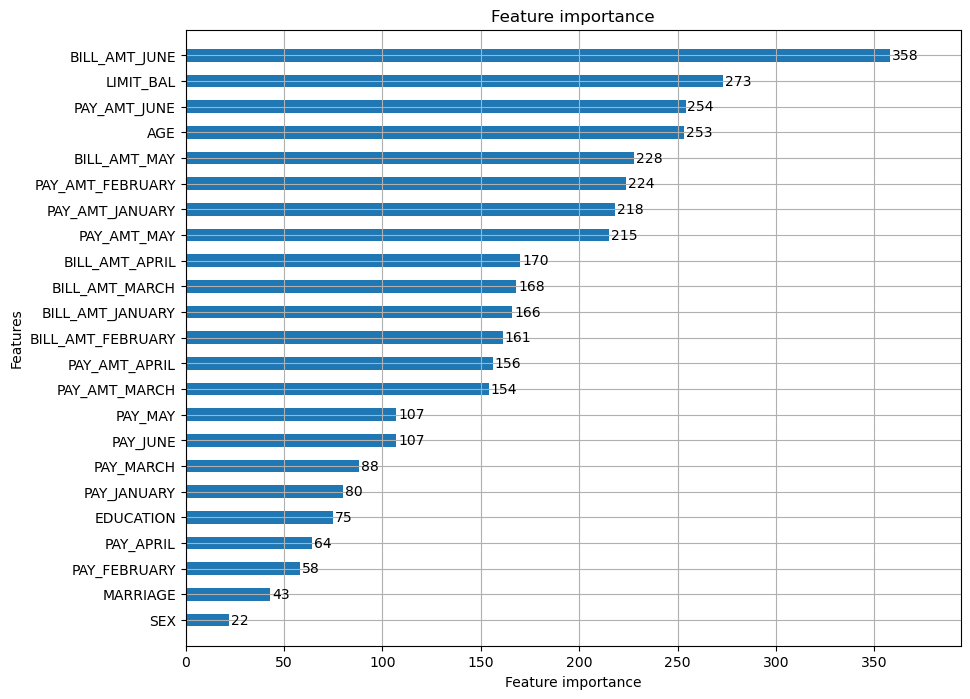

In [201]:
# Load your data
# Assuming you have your data loaded into X (features) and y (target variable)

# Define a pruning callback function
def callback(study, trial):
    if study.best_trial is not None and study.best_trial.number != trial.number:
        if trial.should_prune():
            return True
    return False

# Define objective function for Optuna
def objective(trial):
    params = {
        # 'objective': 'binary',
        # 'metric': 'binary_logloss', #Gives a better score than auc?
        # 'num_leaves': trial.suggest_int('num_leaves', 6, 50),  #
        # 'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.8),
        # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        # 'max_depth': trial.suggest_int('max_depth', 3, 15), # NEW
        'verbose': -1,
        'objective': 'binary',
        'metric': 'binary_logloss', #'auc' #Gives a better score than auc?
        'num_leaves': trial.suggest_int('num_leaves', 5, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.9),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0)
    }

    lgb_classifier = LGBMClassifier(**params)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

    return cross_val_score(lgb_classifier, X, y, cv=cv, scoring=scorer).mean()

# Perform hyperparameter tuning with Optuna
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=5000, callbacks=[callback])  # Pass the callback function directly

# Get the best hyperparameters found by Optuna
best_params = study.best_params

# Train the final model using the best hyperparameters
final_model = LGBMClassifier(**best_params)
final_model.fit(X, y)

lgb.plot_importance(final_model, height=0.5, figsize=(10, 8))
plt.show()


In [202]:
print("Best parameters:", best_params)
# study.best_params['max_depth']

with open('lgbm_hyperparameters3.json', 'w') as f:
    json.dump(best_params, f)

Best parameters: {'num_leaves': 1000, 'max_depth': 6, 'learning_rate': 0.044642636752917075, 'feature_fraction': 0.5106510494513434, 'bagging_fraction': 0.8621655870184399, 'bagging_freq': 2, 'min_child_samples': 34, 'reg_alpha': 4.465018865955098, 'reg_lambda': 4.761964973978054e-08}


## Kaggle Submission

In [203]:
# Extract features
X_submission = submission_features.drop(columns=['ID'])
#X_submission = submission_features.drop(columns=['ID', 'SEX', 'PAY_MARCH', 'MARRIAGE'])

# Calculate probabilities for Kaggle submission
submission_predictions = final_model.predict_proba(X_submission)[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame({'ID': submission_features['ID'], 'DEFAULT_JULY': submission_predictions})

# Save the submission DataFrame to a CSV file
# filename = input("Please enter filename: ")
# submission_df.to_csv(f"{filename}.csv", index=False)
submission_df.to_csv("submission_final3.csv", index=False)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5106510494513434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106510494513434
[LightGBM] [Warning] bagging_fraction is set=0.8621655870184399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621655870184399


## Export Model

In [3]:
joblib.dump(final_model, 'lgbm_optuna_model-finalforreal2.pkl')
loaded_model = joblib.load('lgbm_optuna_model-finalforreal2.pkl')

### Optimize Threshold for Back Profit

The bank wants to optimize the decision-making process by establishing the optimal threshold for the model in order to effectively take the decision about when to issue the credit and when not. So, taking into account the following numbers:

- A customer who received a loan but doesn't repay costs 5000$ to the bank
- A customer who receives a loan and repays, make a profit of 1000$ to the bank
- If the credit is not issued, then there is no profit or loss

In [5]:
# # Load Model
# loaded_model = joblib.load('lgbm_optuna_model-final.pkl')

#Load Best Hyperparameters
with open('lgbm_hyperparameters3.json', 'r') as f:
    loaded_params = json.load(f)

Since the train and test were used to train the model (in order to maximize Kaggle Score) and test data will be used to calculate the optimal threshold: I will retrain the model on only the train_data with the best hyperparameter from the final model above.

In [7]:
train_data = pd.read_csv('train_data.csv')

X_train = train_data.drop(columns=['DEFAULT_JULY', 'ID'])  # Features
y_train = train_data['DEFAULT_JULY']  # Target variable

# Create an LGBMClassifier instance
new_model = LGBMClassifier(**loaded_params)

# Train the classifier
new_model.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5106510494513434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106510494513434
[LightGBM] [Warning] bagging_fraction is set=0.8621655870184399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621655870184399
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5106510494513434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106510494513434
[LightGBM] [Warning] bagging_fraction is set=0.8621655870184399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621655870184399
[LightGBM] [Info] Number of positive: 3341, number of negative: 11659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can 

LGBMClassifier(bagging_fraction=0.8621655870184399, bagging_freq=2,
               feature_fraction=0.5106510494513434,
               learning_rate=0.044642636752917075, max_depth=6,
               min_child_samples=34, num_leaves=1000,
               reg_alpha=4.465018865955098, reg_lambda=4.761964973978054e-08)

In [8]:
test_data = pd.read_csv('test_data.csv')
X_test = test_data.drop(columns=['DEFAULT_JULY', 'ID']) 
y_test = test_data['DEFAULT_JULY'] 

In [9]:
#define whether a customer will cost or profit

def profit(fact, pred):
    if fact + pred == 2: #True Postive - Deny Loan - 0 profit
        return 0
    elif fact == 0 and pred == 1: #False Negative - Loan Denied even though would have been safe - 0 Profit
        return 0
    elif fact == 1 and pred == 0: #False Postive - Loan Given and Not paid - Lost 5000
        return -5000
    else: # True Negative - Loan Paid - 1000 profit
        return 1000

In [10]:
# 1. Make predictions on the test set
y_pred_proba = new_model.predict_proba(X_test)[:, 1]

# 2. Initials list of thresholds and profits
thresholds = np.linspace(0, 1, 100)
print("first 5 vals of thresholds:", thresholds[:5])

profits = []

# 3. Calculate profit for each threshold value
for th in thresholds:
    y_pred_num = y_pred_proba >= th
    y_pred_num = [1 if x else 0 for x in y_pred_num]
    profits.append(sum([profit(f,p) for f,p in zip(y_test, y_pred_num)]))

result = zip(profits, thresholds)

# 4. Find Max Profit and Optimal Threshold
max_profit = float('-inf')  # Initialize with negative infinity to ensure any profit will be greater
optimal_threshold = None

for profit_val, threshold_val in result:
    if profit_val > max_profit:
        max_profit = profit_val
        optimal_threshold = threshold_val

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5106510494513434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106510494513434
[LightGBM] [Warning] bagging_fraction is set=0.8621655870184399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621655870184399
first 5 vals of thresholds: [0.         0.01010101 0.02020202 0.03030303 0.04040404]
Maximum Profit: 1915000
Threshold for Maximum Profit: 0.20202020202020204


In [ ]:
print("Maximum Profit:", max_profit)
print("Threshold for Maximum Profit:", optimal_threshold)

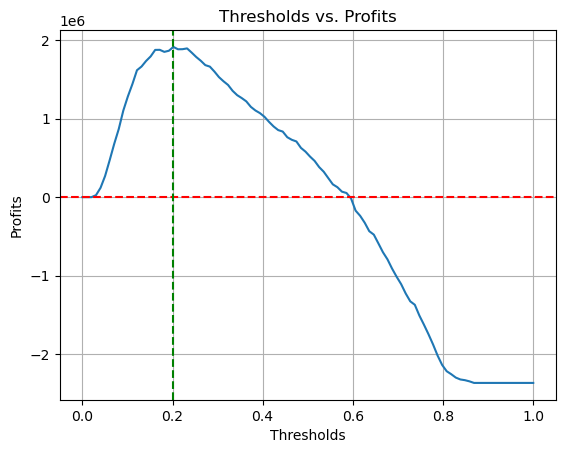

In [11]:
# Plot thresholds vs. profits
plt.plot(thresholds, profits)
plt.xlabel('Thresholds')
plt.ylabel('Profits')
plt.title('Thresholds vs. Profits')
plt.grid(True)

plt.axhline(0, color='r', linestyle='--', label='Zero Profit')
plt.axvline(optimal_threshold, color='g', linestyle='--', label='Max Profit Threshold')
plt.show()

In [12]:
# Save the optimal threshold to a JSON file
with open('threshold.json', 'w') as f:
    json.dump({'threshold': float(optimal_threshold)}, f)

In [13]:
# Convert predicted probabilities to binary predictions based on the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Count the number of rows in y_test that would fall above the optimal threshold
count_above_threshold = np.sum(y_pred_optimal == 1)

print("Number of rows in y_test that would fall above the optimal threshold:", count_above_threshold)
print("Number of rows in y_test:", len(y_test))

# Filter y_test based on the optimal threshold
y_test_above_threshold = y_test[y_pred_proba >= optimal_threshold]
y_test_below_threshold = y_test[y_pred_proba < optimal_threshold]

# Count the number of occurrences of 1 in the filtered y_test
count_above_threshold_and_1 = np.sum(y_test_above_threshold == 1)
count_above_threshold_and_0 = np.sum(y_test_above_threshold == 0)
count_below_threshold_and_1 = np.sum(y_test_below_threshold == 1)
count_below_threshold_and_0 = np.sum(y_test_below_threshold == 0)


print("Number of rows in y_test that fall above the optimal threshold and are 1:", count_above_threshold_and_1)
print("Number of rows in y_test that fall above the optimal threshold and are 0:", count_above_threshold_and_0)
print("Number of rows in y_test that fall below the optimal threshold and are 1:", count_below_threshold_and_1)
print("Number of rows in y_test that fall below the optimal threshold and are 0:", count_below_threshold_and_0)

print("Sum:", count_above_threshold_and_1 + count_above_threshold_and_0 + count_below_threshold_and_1 + count_below_threshold_and_0)



Number of rows in y_test that would fall above the optimal threshold: 2761
Number of rows in y_test: 8000
Number of rows in y_test that fall above the optimal threshold and are 1: 1174
Number of rows in y_test that fall above the optimal threshold and are 0: 1587
Number of rows in y_test that fall below the optimal threshold and are 1: 554
Number of rows in y_test that fall below the optimal threshold and are 0: 4685
Sum: 8000
